In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
# Scenario folder
folder = '../logs/commons_harvest_ablation'
indicators_filename = 'custom_indicators.json'
rewards_history_filename = 'rewards_history.txt'

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

In [2]:
def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

In [31]:
def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1
    if kwargs['scale_xticks']:
        positions = positions*kwargs['scale_xticks']
    if kwargs['xticks_translation']:
        positions += kwargs['xticks_translation']

    fig, ax = plt.subplots(**kwargs.get('subplots_kwargs',{}))
    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        
        ax.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], kwargs['xticks_names'] if kwargs['xticks_names'] else categories, rotation=30)
    else:
        plt.xticks(positions, kwargs['xticks_names'] if kwargs['xticks_names'] else subcategories, rotation=30)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcategories)]
        plt.legend(handles=legend_elements, loc='upper right')

    return ax


def create_line_plot(results, subcat_colors, agg=np.mean, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    agg (function): The function to aggregate the results. There should be a single value per category-subcategory
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    subcategories = list(results[categories[0]].keys())
    # results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations

    # if norm_across_cats and categories is not None:
    #     # Mask to avoid division by zero
    #     mask = results.sum(axis=0, keepdims=True) == 0
    #     results = results/(results.sum(axis=0, keepdims=True)+mask)

    positions = np.arange(len(categories))

    for s, subcategory in enumerate(subcategories):
        data = [agg(results[c][subcategory]) for c in categories]
        plt.plot(data, label=subcategory, color=subcat_colors[s]['color'])

    plt.xticks(positions, categories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])

    legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                            label=subcategory) for i, subcategory in enumerate(subcategories)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

In [27]:
def agents_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

In [28]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

# Reward analysis

In [29]:
def get_metrics_of_simulation(filename):
    rewards = {}
    exec_time = 0
    total_cost = 0
    with open(filename, 'r') as f:
        reward_patt = r'.*end_game:\d+ - Player (\w+): score is (\d+(\.\d+)?)'
        time_patt = r'.* - Execution time: (\d+(\.\d+)?)'
        cost_patt = r'.*- LLM total cost: (\d+(\.\d+)?)'
        for line in f:
            m_reward = re.search(reward_patt, line)
            m_time = re.search(time_patt, line)
            m_cost = re.search(cost_patt, line)
            if m_reward:
                rewards[m_reward.group(1)] = float(m_reward.group(2))
            elif m_cost:
                total_cost = float(m_cost.group(1))
            elif m_time:
                exec_time = float(m_time.group(1))
    return rewards, exec_time, total_cost

In [8]:
rewards = {}
costs = {}
exec_times = {}
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    # modules = os.listdir(model_path)

    # rewards[model] = {}
    # costs[model] = {}
    # exec_times[model] = {}

    # Iterate over the LLMs per agent architecture
    # for module in modules:

    rewards[model] = []
    costs[model] = []
    exec_times[model] = []

    # Iterate over the simulations
    for sim_folder in os.listdir(model_path):
        # skip if it is not a folder
        if not os.path.isdir(os.path.join(model_path, sim_folder)):
            continue

        patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
        folder_time = re.search(patt, sim_folder)
        rewards_filename = folder_time.group() + '.log'

        # Load the rewards of the simulation
        rewards_file = os.path.join(model_path, sim_folder, rewards_filename)
        sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
        rewards[model].append(sim_rewards)
        costs[model].append(sim_cost)
        exec_times[model].append(sim_time)

In [11]:
rewards

{'perceive': [{'Angie': 7.0,
   'David': 13.0,
   'Juan': 9.0,
   'Laura': 2.0,
   'Pedro': 10.0,
   'bot_1': 12.0,
   'bot_2': 22.0},
  {'Angie': 15.0,
   'David': 7.0,
   'Juan': 3.0,
   'Laura': 5.0,
   'Pedro': 7.0,
   'bot_1': 22.0,
   'bot_2': 16.0},
  {'Angie': 4.0,
   'David': 7.0,
   'Juan': 2.0,
   'Laura': 8.0,
   'Pedro': 4.0,
   'bot_1': 17.0,
   'bot_2': 28.0},
  {'Angie': 9.0,
   'David': 5.0,
   'Juan': 13.0,
   'Laura': 10.0,
   'Pedro': 3.0,
   'bot_1': 9.0,
   'bot_2': 26.0},
  {'Angie': 6.0,
   'David': 5.0,
   'Juan': 4.0,
   'Laura': 7.0,
   'Pedro': 9.0,
   'bot_1': 26.0,
   'bot_2': 25.0},
  {'Angie': 10.0,
   'David': 6.0,
   'Juan': 11.0,
   'Laura': 2.0,
   'Pedro': 3.0,
   'bot_1': 12.0,
   'bot_2': 27.0},
  {'Angie': 11.0,
   'David': 2.0,
   'Juan': 10.0,
   'Laura': 6.0,
   'Pedro': 3.0,
   'bot_1': 16.0,
   'bot_2': 26.0},
  {'Angie': 11.0,
   'David': 3.0,
   'Juan': 9.0,
   'Laura': 4.0,
   'Pedro': 8.0,
   'bot_1': 20.0,
   'bot_2': 16.0},
  {'Angie':

In [21]:
rewards['CotAgents'] = [{'Angie': 4.0,
    'David': 3.0,
    'Juan': 4.0,
    'Laura': 1.0,
    'Pedro': 3.0,
    'bot_1': 29.0,
    'bot_2': 25.0},
   {'Angie': 5.0,
    'David': 7.0,
    'Juan': 9.0,
    'Laura': 0.0,
    'Pedro': 6.0,
    'bot_1': 21.0,
    'bot_2': 29.0},
   {'Angie': 10.0,
    'David': 13.0,
    'Juan': 10.0,
    'Laura': 3.0,
    'Pedro': 9.0,
    'bot_1': 14.0,
    'bot_2': 10.0},
   {'Angie': 6.0,
    'David': 0.0,
    'Juan': 4.0,
    'Laura': 4.0,
    'Pedro': 11.0,
    'bot_1': 25.0,
    'bot_2': 23.0},
   {'Angie': 5.0,
    'David': 10.0,
    'Juan': 3.0,
    'Laura': 8.0,
    'Pedro': 12.0,
    'bot_1': 15.0,
    'bot_2': 25.0},
   {'Angie': 11.0,
    'David': 9.0,
    'Juan': 7.0,
    'Laura': 3.0,
    'Pedro': 9.0,
    'bot_1': 17.0,
    'bot_2': 20.0},
   {'Angie': 8.0,
    'David': 8.0,
    'Juan': 5.0,
    'Laura': 3.0,
    'Pedro': 0.0,
    'bot_1': 24.0,
    'bot_2': 25.0},
   {'Angie': 3.0,
    'David': 4.0,
    'Juan': 1.0,
    'Laura': 9.0,
    'Pedro': 9.0,
    'bot_1': 27.0,
    'bot_2': 16.0},
   {'Angie': 7.0,
    'David': 7.0,
    'Juan': 4.0,
    'Laura': 13.0,
    'Pedro': 4.0,
    'bot_1': 12.0,
    'bot_2': 26.0},
   {'Angie': 4.0,
    'David': 10.0,
    'Juan': 7.0,
    'Laura': 3.0,
    'Pedro': 7.0,
    'bot_1': 19.0,
    'bot_2': 29.0}]

In [22]:
rewards_results = {}
for arch in rewards:
    rewards_results[arch] = {}
    data = list(map(lambda x: (x['Juan'] + x['Laura'] + x['Pedro'] + x['David'] + x['Angie'])/5, rewards[arch]))
    rewards_results[arch] = {'mean': np.mean(data), 'std': np.std(data)}

# Make a table with the costs
df = pd.DataFrame(rewards_results)
df

,perceive,reflection,planing,CotAgents
mean,6.866667,8.840000,8.520000,6.10000
std,0.933333,0.924338,1.750885,1.67869


In [23]:
llms = ['reflection', 'planing', 'perceive', 'CotAgents']
rewards_results = {}
rewards_results['GenAgents'] = [7.8, 9.4, 7.8, 8.2, 8.4, 9.2, 7.4, 10.8, 8.6, 8.4]
for llm in llms:
    rewards_results[llm] = agents_mean(rewards[llm], None)
rewards_results

{'GenAgents': [7.8, 9.4, 7.8, 8.2, 8.4, 9.2, 7.4, 10.8, 8.6, 8.4],
 'reflection': [8.2, 9.6, 9.0, 8.6, 7.2, 9.0, 9.0, 7.6, 10.2, 10.0],
 'planing': [10.4, 5.4, 7.0, 7.4, 10.4, 11.4, 7.2, 8.4, 9.0, 8.6],
 'perceive': [8.2, 7.4, 5.0, 8.0, 6.2, 6.4, 6.4, 7.0, 7.2],
 'CotAgents': [3.0, 5.4, 9.0, 5.0, 7.6, 7.8, 4.8, 5.2, 7.0, 6.2]}

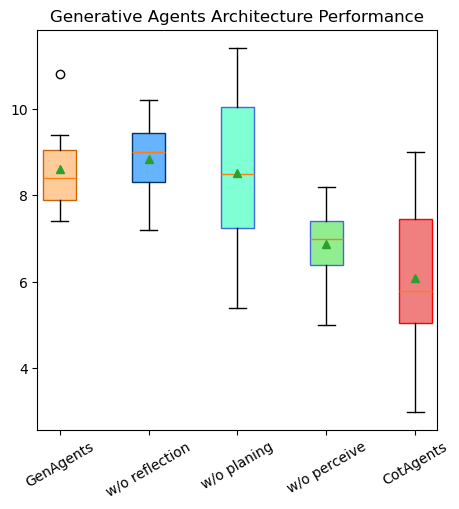

In [33]:
# rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, agents_mean)

subcat_colors = [
    {"facecolor": "#ffcc99", "color": "#cc6600"},  # GPT4o-mini (CoTAgents y GenAgents)
    {"facecolor": "#66b3ff", "color": "#003366"},   # GPT4o (CoTAgents y GenAgents)
    {'facecolor': 'aquamarine', 'color': 'royalblue'}, # Llama 70b
    {'facecolor': 'lightgreen', 'color': 'royalblue'}, # Llama 8b
    {'facecolor': 'lightcoral', 'color': 'red'}, # MeltingPot
]
title = 'Generative Agents Architecture Performance'
ax = create_box_plot(rewards_results, subcat_colors, title=title, scale_xticks=0.4, 
                     xticks_translation=-0.3, subplots_kwargs={'figsize':(5,5)},
                     xticks_names=['GenAgents', 'w/o reflection', 'w/o planing', 'w/o perceive', 'CotAgents']
                     )
# ax.margins(0)
ax.set_xlim(0, 1.8)
plt.subplots_adjust(left=0, right=0.8, top=0.9, bottom=0.1)
plt.show()